In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from PIL import Image
import cv2

# Problem 1

### 2D Convolution Function

In [3]:
def conv2(F, W, PAD, grey=False):
    '''
    Computes the 2D convolution of a kernel with an image. Automatically pads
    accoriding to the kernel dimensions to maintain the original images size.
    If the image is 3D, computes the 2D convolution accross each channel seperately.

    Args:
        F: image to filter/convolute, specified as either
             - a string containing the path to the image
             - a np.ndarrary
        W: kernel to convolute across image
             - np.ndarray of 2D filter weights
        PAD: padding type to be applied to image.
             - Clip: zero padding
             - wrap: wraps the opposite edge over
             - edge: copies the edge pixels
             - reflect: refelcts the pixels across the edge
        grey: Specifies if F is to be read as a greyscale image
             - Default value is False
             - Pass true to return a greyscale image
    '''
######################## Preprocessing ########################
    # Check if image or debug array
    image = False
    if isinstance(F, str):
        if grey: F = cv2.imread(F, cv2.IMREAD_GRAYSCALE)
        else: F = cv2.imread(F)
        image = True

    # Get image basics
    FSize = F.shape
    RGB = False
    if F.ndim > 2:
        RGB = True
        
    if W.ndim == 1:
        W = W.reshape(1,W.shape[0])
    if W.ndim > 2:
        WRows = W.shape[1]
        WColumns = W.shape[2]
    else:
        WRows = W.shape[0]
        WColumns = W.shape[1]

    # Create kernel class
    class KernelObj():
        def __init__(self, W):
            self.rDim = WRows
            self. cDim = WColumns
            self.weights = W.flatten()
            self.padSizes()
            self.setRefPix()
            self.pixels = list(product(range(0,self.rDim), range(0,self.cDim)))

        # Get padding dimensions
        def padSizes(self):
            # Image padding & set refpix
            self.rPadBSize = int(np.floor(self.rDim / 2)) # padding width on rows
            self.cPadRSize = int(np.floor(self.cDim / 2)) # padding width on columns
            if self.rDim % 2 == 0: # if rows even
                self.rPadTSize = int(self.rDim/2 - 1)
            else: # if rows odd
                self.rPadTSize = self.rPadBSize
            if self.cDim % 2 == 0: # if columns even
                self.cPadLSize = int(self.cDim/2 - 1)
            else: # if columns odd
                self.cPadLSize = self.cPadRSize
        
        # Set starting reference pixel coordinate
        def setRefPix(self):
            if self.rDim % 2 == 0: # if rows even
                refpixR = int(self.cDim/2 - 1)
            else: # if rows odd
                refpixR = int((self.cDim + 1)/2 - 1)
            if self.cDim % 2 == 0: # if columns even
                refpixC = int(self.cDim/2 - 1)
            else: # if columns odd
                refpixC = int((self.cDim + 1)/2 - 1)
            self.refpix = (refpixR, refpixC)

        # Slides kernel 1 column to the right
        def slide(self):
            self.refpix = (self.refpix[0], self.refpix[1] + 1)
            self.pixels = [(pixel[0], pixel[1] + 1) for pixel in self.pixels]

        # Moves kernel to next row down
        def nextrow(self,i):
            # Reset refpix and pixels
            self.setRefPix()
            self.refpix = (self.refpix[0] + i, self.refpix[1])
            self.pixels = list(product(range(i, self.rDim + i), range(0, self.cDim)))

    # Create kernel instance    
    kernel = KernelObj(W)

######################## Pad image ########################
    match PAD:
        case 'clip':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='constant', constant_values=0)
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='constant', constant_values=0)
        case 'wrap':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='wrap')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='wrap')
        case 'edge':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='edge')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='edge')
        case 'reflect':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='symmetric')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='symmetric')

######################## Convolution ########################
    # Output of convolution
    outputF = np.zeros(FSize)

    if RGB:
        channels = 3
        # Iterate through original F size but operate on paddedF
        for row in range(FSize[0]):
            for column in range(FSize[1]):
                for channel in range(0,channels):
                    singleChannelPaddedF = paddedF[:,:,channel]
                    # Convolve kernel with windowed pixels in paddedF
                    rPixels, cPixels = zip(*kernel.pixels)
                    windowedPixels = singleChannelPaddedF[rPixels, cPixels]
                    #windowedPixels = windowedPixels.reshape(kernel.rDim, kernel.cDim)
                    convOutput = np.sum((kernel.weights * windowedPixels), axis=None)
                    # Store output in resulting image
                    outputF[row, column, channel] = convOutput
                    
                # Slide the kernel one column to the right
                kernel.slide()
            # Move kernel onto next row
            kernel.nextrow(row + 1)
    else:
        for row in range(FSize[0]):
            for column in range(FSize[1]):
                # Convolve kernel with windowed pixels in paddedF
                rPixels, cPixels = zip(*kernel.pixels)
                windowedPixels = paddedF[rPixels, cPixels]
                convOutput = np.sum((kernel.weights * windowedPixels), axis=None)
                # Store output in resulting image
                outputF[row,column] = convOutput

                # Slide the kernel one column to the right
                kernel.slide()
            # Move kernel onto next row
            kernel.nextrow(row + 1)

    # Normalize and convert    min = np.min(outputF)
    min = np.min(outputF)
    # max = np.max(outputF)
    outputF = (outputF - min) / (255 - min) * 255
    outputF = outputF.astype(np.uint8)
    
    #if image: outputF = Image.fromarray(outputF)
    if image and RGB: 
        outputF = cv2.cvtColor(outputF, cv2.COLOR_BGR2RGB)
        paddedF = cv2.cvtColor(paddedF, cv2.COLOR_BGR2RGB)

    return outputF, paddedF

### a.) Filters

In [4]:
Box = 1/9 * np.array([[[1,1,1],
                       [1,1,1],
                       [1,1,1]]])

FirstOrderX = np.array([-1, 1])

FirstOrderY = np.array([[1],
                       [-1]])

PrewittX = np.array([[[-1,0,1],
                      [-1,0,1],
                      [-1,0,1]]])

PrewittY = np.array([[[1,1,1],
                      [0,0,0],
                    [-1,-1,-1]]])

SobelX = np.array([[[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]]])

SobelY = np.array([[[1,2,1],
                    [0,0,0],
                  [-1,-2,-1]]])

RobertsX = np.array([[0, 1],
                     [-1, 0]])

RobertsY = np.array([[1, 0],
                     [0, -1]])

UnitBoxFilter = np.ones((25,25))

wolves = 'wolves.png'
lena = 'lena.png'

### Run Sample

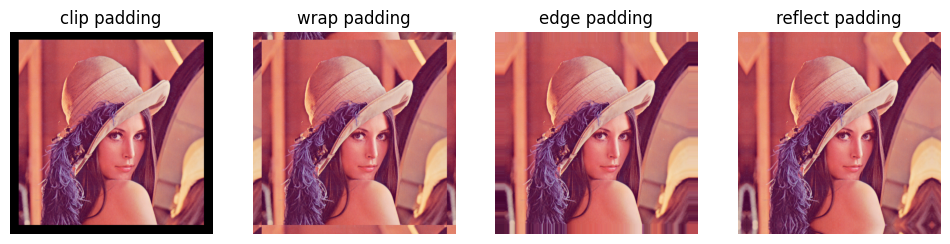

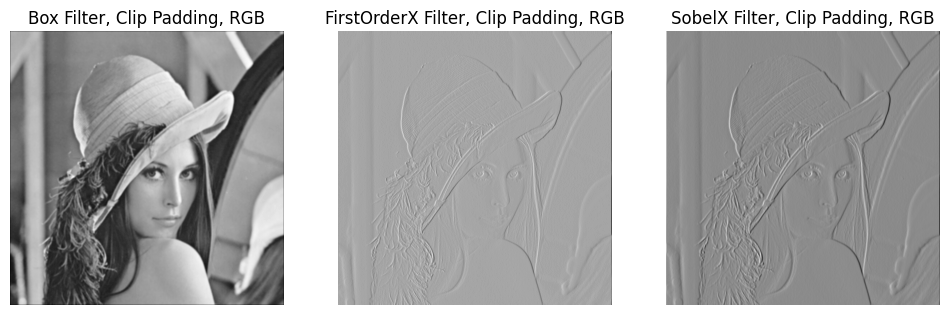

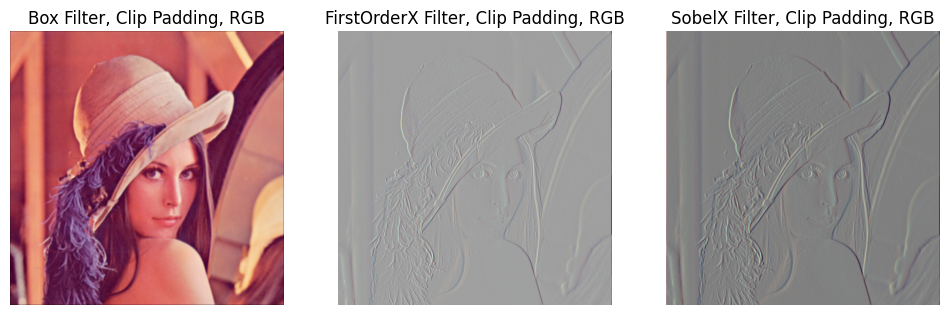

In [32]:
# Image Padding
paddings = ['clip','wrap','edge','reflect']
images = []
plt.figure(figsize=(12, 12))
for i, padding in enumerate(paddings):
    _, image = conv2(lena, UnitBoxFilter, paddings[i])
    images.append(image)
    plt.subplot(1,4,i+1)
    plt.imshow(images[i])
    plt.title(f'{paddings[i]} padding')
    plt.axis('off')

filters = [Box, FirstOrderX, SobelX]
filterNames = ['Box','FirstOrderX','SobelX']

# Greyscale Filtering
images = []
plt.figure(figsize=(12, 12))
for i, filter in enumerate(filters):
    image, _ = conv2(lena, filter, 'clip', True)
    images.append(image)
    plt.subplot(1,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'{filterNames[i]} Filter, Clip Padding, RGB')
    plt.axis('off')

# RGB Filtering
images = []
plt.figure(figsize=(12, 12))
for i, filter in enumerate(filters):
    image, _ = conv2(lena, filter, 'clip')
    images.append(image)
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title(f'{filterNames[i]} Filter, Clip Padding, RGB')
    plt.axis('off')

### b.)

Text(0.5, 1.0, 'Zoomed In Center 5x5 Image')

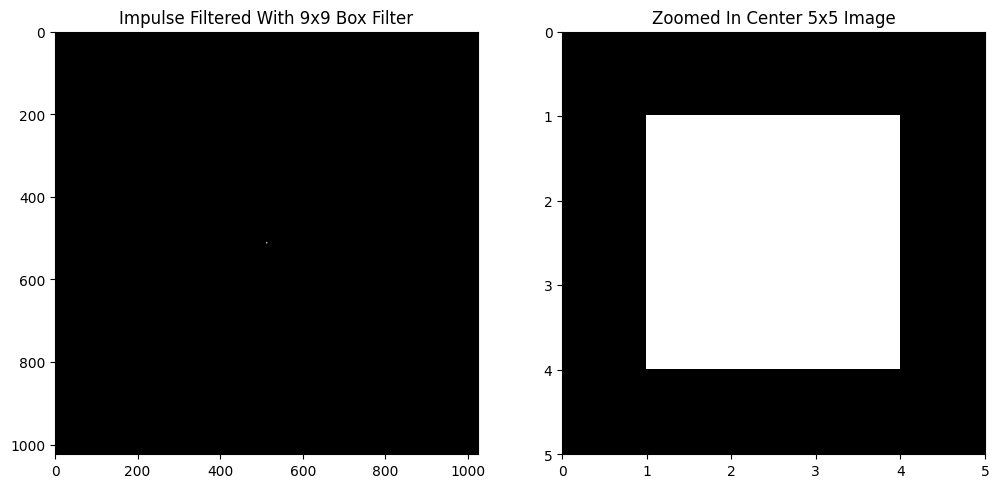

In [25]:
# Create a 1024x1024 array of zeros
Impulse = np.zeros((1024, 1024))
# Impulse at center (255,255)
Impulse[512, 512] = 255

# Convolve with FirstOrderX and show
convolvedImpulse, _ = conv2(Impulse, Box, 'clip', True)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(convolvedImpulse, cmap='gray')
plt.title('Impulse Filtered With 9x9 Box Filter')
plt.subplot(1,2,2)
plt.imshow(convolvedImpulse[512-2:512+3,512-2:512+3], cmap='gray', extent=[0, 5, 5, 0])
plt.title('Zoomed In Center 5x5 Image')

In [8]:
nonZero = np.nonzero(convolvedImpulse)
nonZero = list(zip(*nonZero))
print(f'Total White Pixels: {len(nonZero)}\n')
print('Center 25 Pixels:')
print(convolvedImpulse[512-2:512+3,512-2:512+3])

Total White Pixels: 9

Center 25 Pixels:
[[  0   0   0   0   0]
 [  0 255 255 255   0]
 [  0 255 255 255   0]
 [  0 255 255 255   0]
 [  0   0   0   0   0]]


The combination of the total number of resulting white pixels equalling 3x3 and the center of the resulting 3x3 white square being centered around (512,512) proves that the convolution is working as expected. When the bottom right most corner of the kernel hits the impulse, this will result in the the center pixel of that kernel, currently a diagonal (8-adjacent) distance of 1 pixel away. This will occur for the next pixel right above the impulse, and so on. This wil result in a 3x3 impulse square centered around (512,512).

# Problem 2

### a.) DFT2 Function

In [5]:
def DFT2(f):
    '''
    Computes the 2D DFT of an image. 

    Args:
        f: spatial domain image.
    Returns:
        unshiftedF: Uncentered frequency domain representation 
                    of the image.
        mangitude: Centered magnitude component of F.
        phase: Centered magnitude component of F.
    '''
    # If complex (ie. if called from IDFT2)
    if not isinstance(f, np.ndarray):
        f = cv2.imread(f, cv2.IMREAD_GRAYSCALE)

    # Normalize image
    if f.dtype != 'complex128':
        min = np.min(f)
        max = np.max(f)
        f = (f - min) / (max - min)
    # If complex (ie. if called from IDFT2)
    else:
        complexMagnitudes = np.abs(f)
        maxMag = np.max(complexMagnitudes)
        f = f / maxMag

    # Calculate fft
    rowsFFT = np.fft.fft(f, axis=0) # fft of rows first
    F = np.fft.fft(rowsFFT, axis=1) # then fft of ^^
    unshiftedF = F
    #Center
    F = np.fft.fftshift(F)
    magnitude = np.abs(F)
    phase = np.angle(F)
    # Perform log transfrom
    magnitude = np.log(1+magnitude)
    return unshiftedF, magnitude, phase

Magnitude and Phase shown in color because it looks cool.


(-0.5, 511.5, 511.5, -0.5)

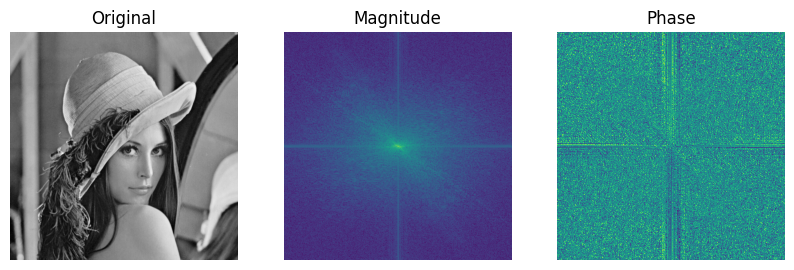

In [10]:
# Call DTFT2 and show frequency components
F, magnitude, phase = DFT2(lena)
original = cv2.imread(lena, cv2.IMREAD_GRAYSCALE)

print('Magnitude and Phase shown in color because it looks cool.')
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(original, cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(magnitude)
plt.title('Magnitude')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(phase)
plt.title('Phase')
plt.axis('off')

### b.) IDFT2 Function

In [26]:
def IDFT2(F):
    '''
    Computes the 2D IDFT of the frequency representation of an image
    using only the DTFT2 function. 
    
    Args:
        F: Frequency representation of an image.
           Returned from DTFT2.
    Returns:
        f: Spatial domain representation of F.
    '''
    M = F.shape[0]
    N = F.shape[1]
    # Call DTFT
    DFToF, _, _ = DFT2(1j * np.conjugate(F))
    # Perform IDFT
    f = 1/(M*N) * np.conjugate(1j * DFToF)
    f = np.abs(f)
    return f

(-0.5, 511.5, 511.5, -0.5)

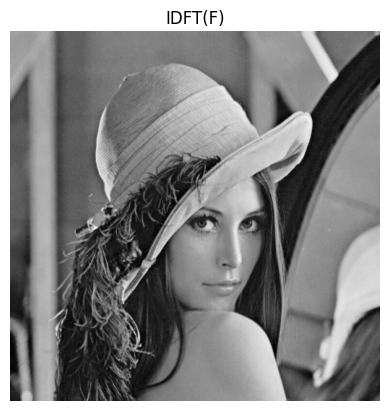

In [23]:
# Call IDFT2 on output of DTFT2
IDFT = IDFT2(F)

plt.imshow(IDFT, cmap = 'gray')
plt.title('IDFT(F)')
plt.axis('off')

### b.) Visualize Difference

(-0.5, 511.5, 511.5, -0.5)

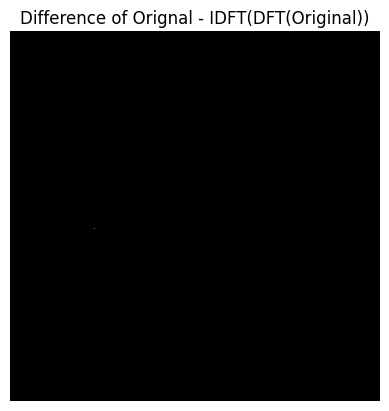

In [24]:
# Normalize and dtype conversion
original = cv2.imread(lena, cv2.IMREAD_GRAYSCALE)
max = np.max(original)
min = np.min(original)
original = (original - min) / (max - min) * 255
original = original.astype('uint8')

max = np.max(IDFT)
min = np.min(IDFT)
IDFT = (IDFT - min) / (max - min) * 255
IDFT = IDFT.astype('uint8')

# Difference
difference = original - IDFT
#nonzeros = [val for val in difference if any(difference != 0)]

plt.imshow(difference, cmap = 'gray')
plt.title('Difference of Orignal - IDFT(DFT(Original))')
plt.axis('off')